# 🎓 Gaussian Fitting and Peak Detection
Welcome to this interactive notebook for exploring Gaussian fitting and peak detection.

In this notebook, you will:
- Upload your own data file (.csv or .xls)
- Select which columns represent X and Y
- Detect peaks in your data
- Fit your data to a sum of Gaussian curves
- Evaluate fit quality using statistics
- Export results and plots

Let's get started!

In [1]:
# 📦 Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from ipywidgets import interact, widgets, fixed
from IPython.display import display, clear_output
from datetime import datetime
import io
from google.colab import files

## 📁 Upload Your Data File
Use the widget below to upload a `.csv` or `.xls` file containing your data.

In [3]:
# Upload file
uploaded = files.upload()

# Load the file into a DataFrame
for fname in uploaded:
    if fname.endswith('.csv'):
        df = pd.read_csv(io.BytesIO(uploaded[fname]))
    elif fname.endswith('.xls') or fname.endswith('.xlsx'):
        df = pd.read_excel(io.BytesIO(uploaded[fname]))
    else:
        raise ValueError("Unsupported file format. Please upload a .csv or .xls file.")

print("✅ File loaded successfully!")
df.head()

Saving test_gaussian_data_2.xlsx to test_gaussian_data_2.xlsx
✅ File loaded successfully!


,X,Y,Y_noisy
0,5.800000,0.1,0.103796
1,5.801001,0.1,0.124244
2,5.802001,0.1,0.139637
3,5.803002,0.1,0.072386
4,5.804003,0.1,0.108862


## 📊 Select X and Y Columns
Choose which columns in your data represent the X and Y values for analysis.

In [4]:
# Create dropdowns for column selection
x_dropdown = widgets.Dropdown(options=df.columns.tolist(), description='X Column:')
y_dropdown = widgets.Dropdown(options=df.columns.tolist(), description='Y Column:')
display(x_dropdown, y_dropdown)

Dropdown(description='X Column:', options=('X', 'Y', 'Y_noisy'), value='X')

Dropdown(description='Y Column:', options=('X', 'Y', 'Y_noisy'), value='X')

## 🔍 Peak Detection
Detect peaks in your Y data and visualize them on a plot.

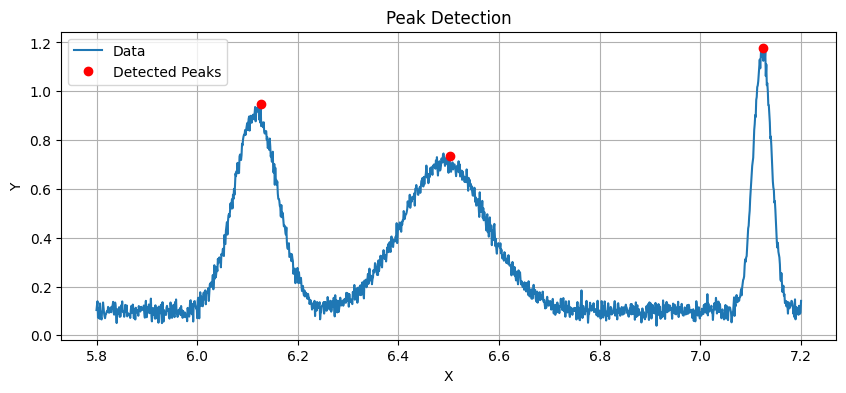

In [24]:
# Detect and plot peaks
def detect_and_plot_peaks(x_col, y_col):
    x = df[x_col].values
    y = df[y_col].values
    peaks, _ = find_peaks(y, height=0.6, threshold = 0.01, distance = 100, prominence=0.01)
    plt.figure(figsize=(10, 4))
    plt.plot(x, y, label='Data')
    plt.plot(x[peaks], y[peaks], 'ro', label='Detected Peaks')
    plt.title('Peak Detection')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()
    return peaks

peaks = detect_and_plot_peaks(x_dropdown.value, y_dropdown.value)

## ✅ Accept or Override Peak Guesses
Choose whether to use the detected peaks or manually input initial guesses.

In [25]:
# Toggle for accepting peak guesses
accept_peaks = widgets.ToggleButtons(
    options=['Accept Detected Peaks', 'Input Manually'],
    description='Peak Init:',
    style={'description_width': 'initial'}
)
display(accept_peaks)

ToggleButtons(description='Peak Init:', options=('Accept Detected Peaks', 'Input Manually'), style=ToggleButto…

## ⚙️ Baseline Toggle
Choose whether to include a baseline in the Gaussian fit.

In [26]:
# Checkbox for baseline fitting
fit_baseline = widgets.Checkbox(value=True, description='Fit Baseline')
display(fit_baseline)

Checkbox(value=True, description='Fit Baseline')

## 📈 Fit Gaussians to Data
Fit the data to a sum of Gaussians using the selected parameters.

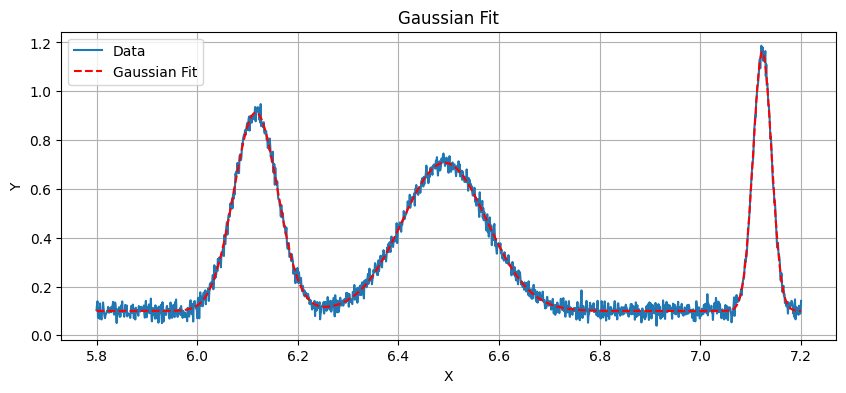

In [29]:
# Define Gaussian model
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2))

def multi_gaussian(x, *params):
    n = (len(params) - 1) // 3 if fit_baseline.value else len(params) // 3
    y = np.zeros_like(x)
    for i in range(n):
        A = params[3*i]
        mu = params[3*i+1]
        sigma = params[3*i+2]
        y += gaussian(x, A, mu, sigma)
    if fit_baseline.value:
        y += params[-1]
    return y

# Prepare initial guesses
x = df[x_dropdown.value].values
y = df[y_dropdown.value].values
if accept_peaks.value == 'Accept Detected Peaks':
    init_params = []
    for p in peaks:
        init_params += [y[p], x[p], 0.1]
    if fit_baseline.value:
        init_params += [np.min(y)]
else:
    num_gaussians = int(input("Enter number of Gaussians: "))
    init_params = []
    for i in range(num_gaussians):
        A = float(input(f"Amplitude {i+1}: "))
        mu = float(input(f"Mean {i+1}: "))
        sigma = float(input(f"Sigma {i+1}: "))
        init_params += [A, mu, sigma]
    if fit_baseline.value:
        init_params += [np.min(y)]

# Fit the model
popt, pcov = curve_fit(multi_gaussian, x, y, p0=init_params)
y_fit = multi_gaussian(x, *popt)
resid = y_fit - y

# Plot fit
plt.figure(figsize=(10, 4))
plt.plot(x, y, label='Data')
plt.plot(x, y_fit, 'r--', label='Gaussian Fit')
plt.title('Gaussian Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

## 📊 Fit Statistics
Evaluate the quality of the fit using R², RMSE, and AIC.

In [30]:
# Compute fit statistics
residuals = y - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
rmse = np.sqrt(ss_res / len(y))
aic = len(y) * np.log(ss_res / len(y)) + 2 * len(popt)

print(f"R²: {r_squared:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"AIC: {aic:.2f}")

R²: 0.9938
RMSE: 0.0203
AIC: -10894.53


## 💾 Export Results
Save the fitted data and plot with a timestamped filename.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Results saved and downloaded as gaussian_fit_20250922_200743.csv and gaussian_plot_20250922_200743.png


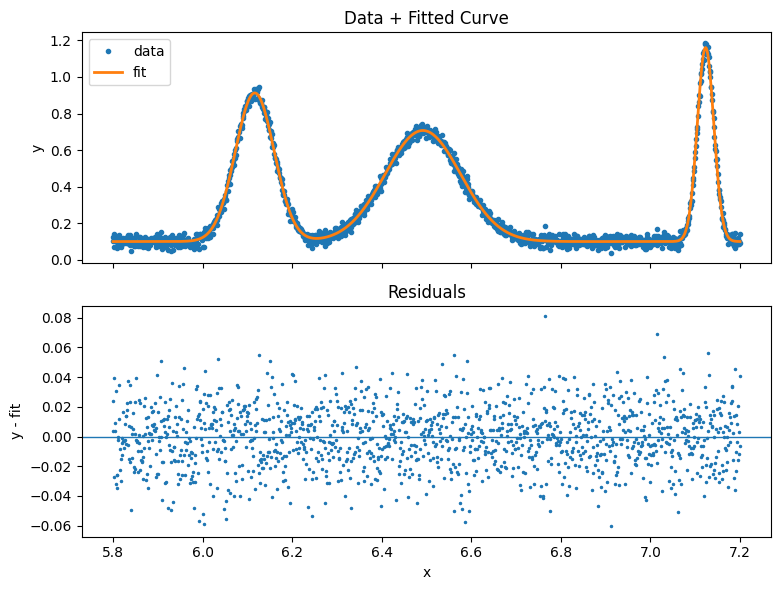

In [35]:
# Export results
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename_csv = f"gaussian_fit_{timestamp}.csv"
filename_png = f"gaussian_plot_{timestamp}.png"

# Save data
result_df = pd.DataFrame({'X': x, 'Y': y, 'Y_Fit': y_fit, 'Residuals': residuals})
result_df.to_csv(filename_csv, index=False)

# Save plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)

# Top: raw data + fitted curve
ax1.plot(x, y, 'o', ms=3, label='data')
ax1.plot(x, y_fit, '-', lw=2, label='fit')
ax1.set_title('Data + Fitted Curve')
ax1.set_ylabel('y')
ax1.legend(loc='best')

# Bottom: residuals
ax2.axhline(0, lw=1)
ax2.plot(x, residuals, '.', ms=3, label='residuals')
ax2.set_title('Residuals')
ax2.set_xlabel('x')
ax2.set_ylabel('y - fit')

plt.tight_layout()
fig.savefig(filename_png, dpi=150, bbox_inches='tight')

files.download(filename_csv)
files.download(filename_png)

print(f"✅ Results saved and downloaded as {filename_csv} and {filename_png}")